### palette experiments v2

In [ ]:
# Cell 1 – Imports, paths, basic config

from pathlib import Path

import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from skimage import color

# Plot defaults
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.grid"] = False

# santafe, albania
PROJECT_SLUG = "santafe"

PROJECT_ROOT = Path("..")
IMAGES_ROOT = PROJECT_ROOT / "data" / "images"
OUTPUT_ROOT = PROJECT_ROOT / "output" / "palettes"

DATA_DIR = IMAGES_ROOT / PROJECT_SLUG
PHOTOS_DIR = DATA_DIR / "photos"

# Collect only photo files (case-insensitive), sorted
PHOTO_EXTS = {".jpg", ".jpeg", ".png", ".tif", ".tiff", ".heic"}
photos = sorted(
    [p for p in PHOTOS_DIR.iterdir() if p.suffix.lower() in PHOTO_EXTS]
)

photos

In [2]:
from PIL import Image


def load_image(path: Path, max_dim: int = 800) -> Image.Image:
    """
    Load an image as RGB and downsize so longest side <= max_dim.
    """
    img = Image.open(path).convert("RGB")
    w, h = img.size
    scale = min(1.0, max_dim / max(w, h))
    if scale < 1.0:
        new_size = (int(w * scale), int(h * scale))
        img = img.resize(new_size, Image.LANCZOS)
    return img


# Collect photos for this project
PHOTO_EXTS = {".jpg", ".jpeg", ".png", ".tif", ".tiff", ".heic"}
photos = sorted(
    [p for p in PHOTOS_DIR.iterdir() if p.suffix.lower() in PHOTO_EXTS]
)
assert photos, f"No photo files found in {PHOTOS_DIR}"

IMAGE_INDEX = 0  # change this to pick another photo
IMAGE_PATH = photos[IMAGE_INDEX]

print(f"Loading image: {IMAGE_PATH}")
img = load_image(IMAGE_PATH, max_dim=800)

# Sanity check
print("Image size:", img.size, " type:", type(img))

Loading image: ../data/palettes/santafe/photos/chumayó_brush.jpg
Image size: (709, 800)  type: <class 'PIL.Image.Image'>


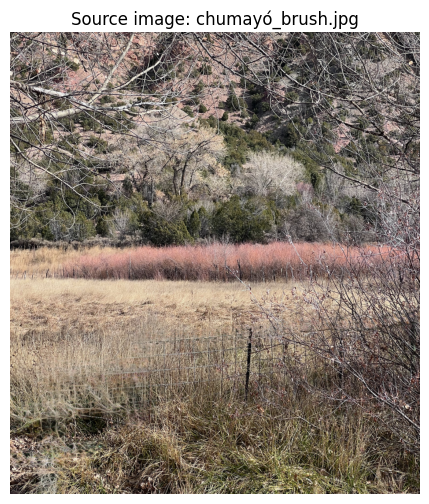

In [3]:
# Cell 3 – Show the source image

plt.figure()
plt.imshow(img)
plt.axis("off")
plt.title(f"Source image: {IMAGE_PATH.name}")  # or .stem if you prefer no extension
plt.show()

In [4]:
# Cell 4 – Helper to sample RGB pixels

def image_to_pixels(image: Image.Image, sample_fraction: float = 0.2, random_state: int = 42) -> np.ndarray:
    """
    Convert an image to a 2D array of pixels [n_samples, 3] in RGB.
    Optionally subsample a fraction of pixels for performance.
    """
    rng = np.random.default_rng(random_state)
    arr = np.array(image)  # shape (H, W, 3)
    h, w, c = arr.shape
    pixels = arr.reshape(-1, c)

    if 0 < sample_fraction < 1.0:
        n_pixels = pixels.shape[0]
        n_sample = int(n_pixels * sample_fraction)
        idx = rng.choice(n_pixels, size=n_sample, replace=False)
        pixels = pixels[idx]

    return pixels.astype(np.float32)

In [5]:
# Cell 5 – Helpers to convert image/palette between RGB and LAB

def rgb_image_to_lab_array(image: Image.Image) -> np.ndarray:
    """
    Convert a PIL RGB image to an array of LAB pixels, shape [H*W, 3].
    """
    rgb = np.array(image) / 255.0  # skimage expects 0–1 float
    lab = color.rgb2lab(rgb)       # shape (H, W, 3)
    h, w, c = lab.shape
    return lab.reshape(-1, c).astype(np.float32)


def lab_array_to_rgb_colors(lab_centers: np.ndarray) -> np.ndarray:
    """
    Convert LAB cluster centers back to RGB colors in 0–255 uint8.
    """
    lab_img = lab_centers.reshape(1, -1, 3)
    rgb = color.lab2rgb(lab_img)  # 0–1 floats
    rgb = np.clip(rgb * 255.0, 0, 255).astype(np.uint8)
    return rgb.reshape(-1, 3)

In [6]:
# Cell 6 – Extract palette via k-means in RGB or LAB

def extract_palette_kmeans(
    image: Image.Image,
    n_colors: int = 6,
    sample_fraction: float = 0.2,
    color_space: str = "rgb",  # "rgb" or "lab"
    random_state: int = 42,
):
    """
    Cluster image pixels into n_colors using k-means in the chosen color space.

    Returns:
        centers_rgb: [n_colors, 3] uint8 RGB colors for display
        counts:      [n_colors] pixel counts per cluster
    """
    if color_space.lower() == "rgb":
        pixels_for_kmeans = image_to_pixels(image, sample_fraction=sample_fraction, random_state=random_state)
    elif color_space.lower() == "lab":
        lab_pixels = rgb_image_to_lab_array(image)
        if 0 < sample_fraction < 1.0:
            rng = np.random.default_rng(random_state)
            n_pixels = lab_pixels.shape[0]
            n_sample = int(n_pixels * sample_fraction)
            idx = rng.choice(n_pixels, size=n_sample, replace=False)
            lab_pixels = lab_pixels[idx]
        pixels_for_kmeans = lab_pixels
    else:
        raise ValueError(f"Unsupported color_space: {color_space}")

    kmeans = KMeans(
        n_clusters=n_colors,
        random_state=random_state,
        n_init="auto",
    )
    labels = kmeans.fit_predict(pixels_for_kmeans)
    centers = kmeans.cluster_centers_

    # Convert cluster centers to displayable RGB
    if color_space.lower() == "rgb":
        centers_rgb = np.clip(centers, 0, 255).astype(np.uint8)
    else:  # LAB
        centers_rgb = lab_array_to_rgb_colors(centers)

    # Count cluster frequencies
    counts = np.bincount(labels, minlength=n_colors)

    # Sort by frequency (descending)
    sort_idx = np.argsort(counts)[::-1]
    centers_rgb = centers_rgb[sort_idx]
    counts = counts[sort_idx]

    return centers_rgb, counts

In [7]:
# Cell 7 – Plot a palette strip and print RGB + proportions

def plot_palette(centers: np.ndarray, counts: np.ndarray, title: str = "Palette"):
    """
    Visualize palette colors in a horizontal bar,
    sized by their relative frequency.
    """
    total = counts.sum()
    proportions = counts / total

    # Create a 1 x N strip where each segment is proportional to color frequency
    width = 800
    height = 100
    palette_img = np.zeros((height, width, 3), dtype=np.uint8)

    current_x = 0
    for color, prop in zip(centers, proportions):
        w = int(prop * width)
        if w <= 0:
            continue
        palette_img[:, current_x:current_x + w, :] = color
        current_x += w

    plt.figure(figsize=(8, 2))
    plt.imshow(palette_img)
    plt.axis("off")
    plt.title(title)
    plt.show()

    # Also print numeric info
    print("Palette colors (RGB + % of image):")
    for i, (color, prop) in enumerate(zip(centers, proportions), start=1):
        r, g, b = color
        print(f"{i}: RGB({r:3d}, {g:3d}, {b:3d})  ~ {prop*100:5.1f}%")

RGB palette centers (uint8 RGB):
[[112 100  88]
 [ 76  67  56]
 [149 134 120]
 [186 166 151]
 [ 35  28  23]
 [220 203 186]]

Cluster counts (most frequent first):
[22869 21825 21286 20099 14974 12387]


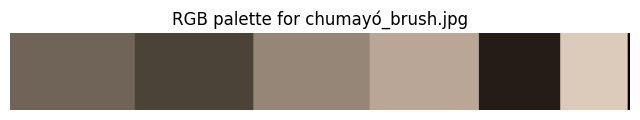

Palette colors (RGB + % of image):
1: RGB(112, 100,  88)  ~  20.2%
2: RGB( 76,  67,  56)  ~  19.2%
3: RGB(149, 134, 120)  ~  18.8%
4: RGB(186, 166, 151)  ~  17.7%
5: RGB( 35,  28,  23)  ~  13.2%
6: RGB(220, 203, 186)  ~  10.9%


In [8]:
# Cell 8 – Compare RGB vs LAB palettes for the current image

# Number of colors to extract
N_COLORS = 6

# Extract palette in RGB space
centers_rgb, counts = extract_palette_kmeans(
    img,
    n_colors=N_COLORS,
    sample_fraction=0.2,
    color_space="rgb",
    random_state=42,
)

# Print centers and counts
print("RGB palette centers (uint8 RGB):")
print(centers_rgb)
print("\nCluster counts (most frequent first):")
print(counts)

# Plot palette strip
plot_palette(
    centers_rgb,
    counts,
    title=f"RGB palette for {IMAGE_PATH.name}",  # <- was IMAGE_NAME
)

In [9]:
# Cell 8A – Save a palette strip as an image (PNG or JPEG)

from PIL import Image as PILImage

def save_palette_image(
    centers: np.ndarray,
    counts: np.ndarray,
    out_path: Path,
    width: int = 1200,
    height: int = 150,
    show_labels: bool = False
):
    """
    Save a horizontal palette strip as a PNG/JPEG file.
    Each color's width is proportional to its relative count.
    """
    total = counts.sum()
    proportions = counts / total

    # Create raw pixel array
    img = np.zeros((height, width, 3), dtype=np.uint8)

    current_x = 0
    for color, prop in zip(centers, proportions):
        w = int(prop * width)
        img[:, current_x:current_x + w, :] = color
        current_x += w

    pil_img = PILImage.fromarray(img)
    pil_img.save(out_path)
    print(f"Saved palette image → {out_path}")

In [10]:
# Cell 9 – Define the image set for a place-level palette (generic)

# Collect all photo files from PHOTOS_DIR (already sorted in Cell 1)
PHOTO_EXTS = {".jpg", ".jpeg", ".png", ".tif", ".tiff", ".heic"}
all_photos = sorted(
    [p for p in PHOTOS_DIR.iterdir() if p.suffix.lower() in PHOTO_EXTS]
)

assert all_photos, f"No photos found in {PHOTOS_DIR}"

# Optionally limit number of photos used for palette
# (None = use all photos in the folder)
MAX_PHOTOS = None   # or e.g. 3, 5, 10, etc.

if MAX_PHOTOS is None:
    IMAGE_PATHS_PLACE = all_photos
else:
    IMAGE_PATHS_PLACE = all_photos[:MAX_PHOTOS]

# Final safety check
for p in IMAGE_PATHS_PLACE:
    assert p.exists(), f"Image not found: {p}"

IMAGE_PATHS_PLACE

[PosixPath('../data/palettes/santafe/photos/chumayó_brush.jpg'),
 PosixPath('../data/palettes/santafe/photos/santafe_01.jpg'),
 PosixPath('../data/palettes/santafe/photos/santafe_02_outskirts.jpg'),
 PosixPath('../data/palettes/santafe/photos/santafe_03_loretto.jpg')]

In [11]:
# Cell 10 – Sample equal numbers of LAB pixels from each image

def sample_lab_pixels_from_images(
    image_paths,
    pixels_per_image: int = 5000,
    max_dim: int = 800,
    random_state: int = 42,
) -> np.ndarray:
    """
    For each image path, load the image, convert to LAB, and randomly sample
    up to `pixels_per_image` pixels. Return all samples stacked together.
    """
    rng = np.random.default_rng(random_state)
    all_samples = []

    for path in image_paths:
        img = load_image(path, max_dim=max_dim)
        lab = rgb_image_to_lab_array(img)  # [H*W, 3]
        n_pixels = lab.shape[0]
        n_sample = min(pixels_per_image, n_pixels)
        idx = rng.choice(n_pixels, size=n_sample, replace=False)
        all_samples.append(lab[idx])

    combined = np.vstack(all_samples)
    print(f"Combined LAB samples shape: {combined.shape}")
    return combined

combined_lab_pixels = sample_lab_pixels_from_images(
    IMAGE_PATHS_PLACE,
    pixels_per_image=8000,
)
combined_lab_pixels.shape

Combined LAB samples shape: (32000, 3)


(32000, 3)

In [ ]:
# Cell 11 – Place-level LAB palette from combined pixels

def kmeans_palette_from_lab_pixels(
    lab_pixels: np.ndarray,
    n_colors: int = 9,
    random_state: int = 42,
):
    """
    Run k-means on LAB pixels and return palette centers in RGB + counts.
    """
    kmeans = KMeans(
        n_clusters=n_colors,
        random_state=random_state,
        n_init="auto",
    )
    labels = kmeans.fit_predict(lab_pixels)
    centers_lab = kmeans.cluster_centers_
    counts = np.bincount(labels, minlength=n_colors)

    # sort by frequency
    sort_idx = np.argsort(counts)[::-1]
    centers_lab = centers_lab[sort_idx]
    counts = counts[sort_idx]

    centers_rgb = lab_array_to_rgb_colors(centers_lab)
    return centers_rgb, counts

centers_place, counts_place = kmeans_palette_from_lab_pixels(
    combined_lab_pixels,
    n_colors=8,  # tweak as desired
)

# Plot palette
plot_palette(
    centers_place,
    counts_place,
    title="Place-level LAB palette (combined images)"
)

# Export palette strip (PNG)
outfile = OUTPUT_ROOT / f"palette_{PROJECT_SLUG}_combined_01.png"
save_palette_image(centers_place, counts_place, outfile)

outfile

Using 4800 of 32000 pixels (15.0%) with chroma >= 20.26


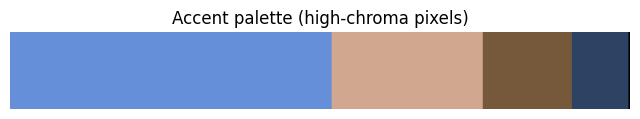

Palette colors (RGB + % of image):
1: RGB(101, 144, 217)  ~  51.9%
2: RGB(209, 168, 143)  ~  24.4%
3: RGB(118,  88,  59)  ~  14.5%
4: RGB( 46,  67, 100)  ~   9.2%


In [13]:
# Cell 12 – Accent palette from high-chroma pixels

def extract_accent_palette(
    lab_pixels: np.ndarray,
    n_colors: int = 4,
    chroma_percentile: float = 85.0,
    random_state: int = 42,
):
    """
    Build an 'accent' palette by keeping only high-chroma pixels (most saturated
    colors) and running k-means on them.
    """
    # LAB: L = brightness, a/b = color-opponent channels
    L = lab_pixels[:, 0]
    a = lab_pixels[:, 1]
    b = lab_pixels[:, 2]

    chroma = np.sqrt(a * a + b * b)

    threshold = np.percentile(chroma, chroma_percentile)
    mask = chroma >= threshold
    high_chroma_pixels = lab_pixels[mask]

    print(
        f"Using {high_chroma_pixels.shape[0]} of {lab_pixels.shape[0]} pixels "
        f"({high_chroma_pixels.shape[0] / lab_pixels.shape[0] * 100:.1f}%) "
        f"with chroma >= {threshold:.2f}"
    )

    centers_rgb, counts = kmeans_palette_from_lab_pixels(
        high_chroma_pixels,
        n_colors=n_colors,
        random_state=random_state,
    )
    return centers_rgb, counts

accent_centers, accent_counts = extract_accent_palette(
    combined_lab_pixels,
    n_colors=4,
    chroma_percentile=85.0,  # try 80–90 range
)

plot_palette(accent_centers, accent_counts, title="Accent palette (high-chroma pixels)")